In [55]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.utils import save_image
from torch import autograd

latent_dim = 100
lr = 0.00005
batch_size = 64
num_epochs = 100
lambda_gp = 10


In [56]:
dir_pokemon = "./archive/pokemon"
files_pokemon = os.listdir(dir_pokemon + '/pokemon')

In [57]:
transform=transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])


batch_size = 350

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset = ImageFolder(root = dir_pokemon, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last = True)

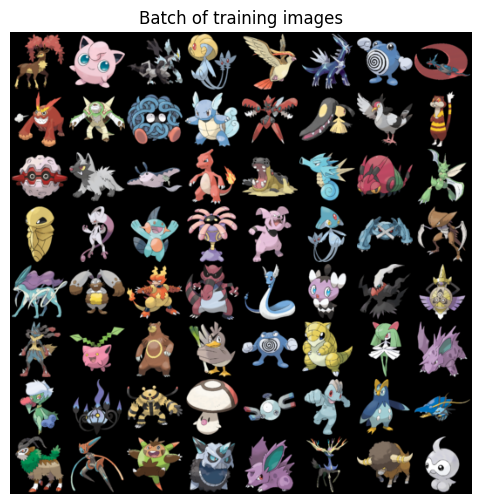

In [58]:
first_batch = next(iter(dataloader))
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Batch of training images")
plt.imshow(vutils.make_grid(first_batch[0][:64], padding=2, normalize=True).cpu().numpy().transpose(1,2,0))
plt.show()

In [59]:
if (os.path.exists("./data")) == False:
    os.mkdir("data")

In [60]:
for data in dataloader:
    print(data[0].size())
    break

torch.Size([350, 3, 64, 64])


In [61]:
class Disc(nn.Module):
    def __init__(self):
        super(Disc, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # (350, 3, 32, 32) -> (350, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (350, 32, 32, 16) -> (350, 64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                           # (350, 64, 16, 16) -> (350, 64, 16, 16)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (64, 16, 16) -> (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # (128, 16, 16) -> (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                            # (128, 16, 16) -> (128, 8, 8)

            nn.Conv2d(128, 128, kernel_size=3, padding=1), # (128, 8, 8) -> (256, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # (256, 8, 8) -> (256, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                            # (256, 8, 8) -> (256, 4, 4)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1),
            nn.ReLU(inplace=True),
        )


    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.classifier(x)
        return x


In [62]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
            )

    def forward(self, z):
        return self.main(z.view(-1, 100, 1, 1))


In [63]:
generator = Generator().to(device)
critic = Disc().to(device)

# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
c_optimizer = torch.optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))

In [64]:
def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = critic(interpolates)
    fake = torch.autograd.Variable(torch.Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:

# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        real_images = images.to(device)

        # Train Critic
        for _ in range(5):
            c_optimizer.zero_grad()
            fake_images = generator(torch.randn(batch_size, 100, device=device))
            real_validity = critic(real_images)
            fake_validity = critic(fake_images) 
            gradient_penalty = compute_gradient_penalty(critic, real_images.data, fake_images.data)

            c_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + gradient_penalty
            c_loss.backward()
            c_optimizer.step()

        g_optimizer.zero_grad()
        gen_imgs = generator(torch.randn(batch_size, 100, device=device))
        g_loss = -torch.mean(critic(gen_imgs))
        g_loss.backward()
        g_optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], C Loss: {c_loss.item()}, G Loss: {g_loss.item()}')

    save_image(fake_images.data[:25], f'./data/fake_images-{epoch+1}.png', nrow=5, normalize=True)

Epoch [1/100], Step [1/2], C Loss: 59.25127410888672, G Loss: -0.10426365584135056
Epoch [1/100], Step [2/2], C Loss: 46.84758377075195, G Loss: -0.10123758763074875
Epoch [2/100], Step [1/2], C Loss: 36.95734786987305, G Loss: -0.10549239814281464
Epoch [2/100], Step [2/2], C Loss: 31.958505630493164, G Loss: -0.09752407670021057
Epoch [3/100], Step [1/2], C Loss: 23.342670440673828, G Loss: -0.10030199587345123
Epoch [3/100], Step [2/2], C Loss: 19.418352127075195, G Loss: -0.09286878257989883
Epoch [4/100], Step [1/2], C Loss: 16.438514709472656, G Loss: -0.10186491906642914
Epoch [4/100], Step [2/2], C Loss: 12.850141525268555, G Loss: -0.10002273321151733
Epoch [5/100], Step [1/2], C Loss: 10.128485679626465, G Loss: -0.10293666273355484
Epoch [5/100], Step [2/2], C Loss: 8.579367637634277, G Loss: -0.09660685807466507
Epoch [6/100], Step [1/2], C Loss: 7.579319477081299, G Loss: -0.10012950003147125
